In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [290]:
data = pd.read_csv("/kaggle/input/gi-th-trng-smp-2021-new/Gia SMP va SMPcap 2021(Gi th trng SMP).csv", encoding='latin-1')
data2 = np.loadtxt('/kaggle/input/gi-th-trng-smp-2021-new/Gia SMP va SMPcap 2021(Gi th trng SMP).csv',encoding='latin-1', delimiter=',', skiprows=1, usecols=(5, 6, 7), dtype=float)

df = data.iloc[:, [6, 7, 8]]  
df.columns = ['Column7', 'Column8', 'Column9']

In [291]:
print(df.describe())

           Column7      Column8      Column9
count   365.000000   365.000000   365.000000
mean   1040.228767  1040.228493  1040.228219
std     105.146665   105.146912   105.147104
min     885.700000   885.700000   885.700000
25%     988.400000   988.400000   988.400000
50%    1022.600000  1022.600000  1022.600000
75%    1061.500000  1061.500000  1061.500000
max    1565.500000  1565.500000  1565.500000


**EDA**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


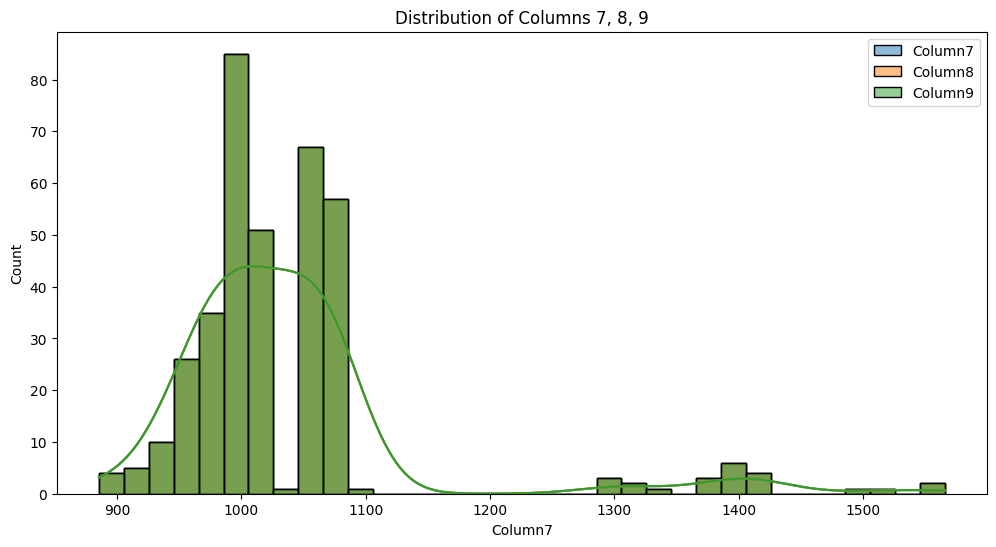

In [292]:
# biểu đồ phân phối
plt.figure(figsize=(12, 6))
sns.histplot(df['Column7'], kde=True, label='Column7')
sns.histplot(df['Column8'], kde=True, label='Column8')
sns.histplot(df['Column9'], kde=True, label='Column9')
plt.legend()
plt.title('Distribution of Columns 7, 8, 9')
plt.show()


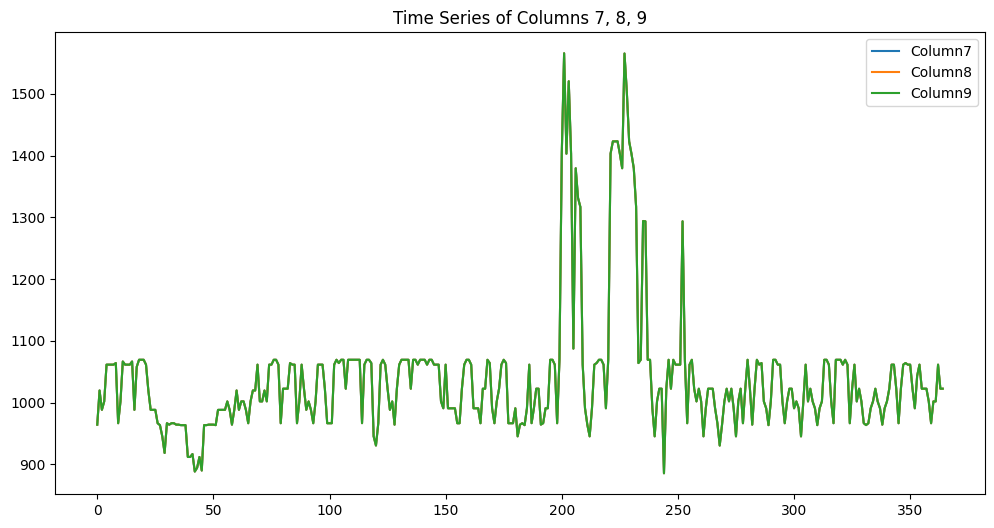

In [ ]:
# biểu đồ thời gian
plt.figure(figsize=(12, 6))
plt.plot(df['Column7'], label='Column7')
plt.plot(df['Column8'], label='Column8')
plt.plot(df['Column9'], label='Column9')
plt.legend()
plt.title('Time Series of Columns 7, 8, 9')
plt.show()


**Kalman Model**

In [294]:
# Khởi tạo biến trạng thái (state vector)
x = np.zeros((3, 1))  # 3 biến trạng thái tương ứng với 3 cột

# Ma trận hiệp phương sai của trạng thái (covariance matrix)
P = np.eye(3)

# Ma trận chuyển tiếp trạng thái (state transition matrix)
F = np.eye(3)

# Ma trận đo lường (measurement matrix)
H = np.eye(3)

# Hiệp phương sai của nhiễu quá trình (process noise covariance)
Q = np.eye(3) * 0.01

# Hiệp phương sai của nhiễu đo lường (measurement noise covariance)
R = np.eye(3) * 0.1

# Vector đo lường (measurement vector)
z = np.zeros((3, 1))


In [295]:
def predict(x, P, F, Q):
    # Dự đoán trạng thái tiếp theo
    x = np.dot(F, x)
    P = np.dot(F, np.dot(P, F.T)) + Q
    return x, P

def update(x, P, z, H, R):
    # Tính toán các giá trị Kalman Gain
    y = z - np.dot(H, x)
    S = np.dot(H, np.dot(P, H.T)) + R
    K = np.dot(P, np.dot(H.T, np.linalg.inv(S)))

    # Cập nhật trạng thái và hiệp phương sai
    x = x + np.dot(K, y)
    P = P - np.dot(K, np.dot(H, P))
    return x, P


In [296]:
filtered_data2 = []

for measurement in data2:
    z = measurement.reshape(3, 1)  # Chuyển đổi đo lường thành vector cột

    # Dự đoán bước tiếp theo
    x, P = predict(x, P, F, Q)

    # Cập nhật với đo lường mới
    x, P = update(x, P, z, H, R)

    # Lưu trữ kết quả đã lọc
    filtered_data2.append(x.flatten())

filtered_data2 = np.array(filtered_data2)


In [297]:
print(filtered_data2)


[[ 877.51711712  877.51711712  877.51711712]
 [ 948.95907665  948.95907665  948.95907665]
 [ 963.78734581  963.78734581  963.78734581]
 ...
 [1020.03041047 1020.03041032 1020.03041032]
 [1020.72460105 1020.72460093 1020.72460093]
 [1021.23125172 1021.23125164 1021.23125164]]


In [298]:
mse_kalman = mean_squared_error(data2, filtered_data2)
mae_kalman = mean_absolute_error(data2, filtered_data2)
rmse_kalman = np.sqrt(mse_kalman)

print("Kalman Filter - MSE:", mse_kalman)
print("Kalman Filter - MAE:", mae_kalman)
print("Kalman Filter - RMSE:", rmse_kalman)

Kalman Filter - MSE: 2793.976037299359
Kalman Filter - MAE: 32.389467693828664
Kalman Filter - RMSE: 52.85807447589591


**SARIMA**

In [299]:
# Định nghĩa các tham số của mô hình SARIMA
order = (1, 1, 1)         # Tham số (p, d, q) cho phần không mùa
seasonal_order = (1, 1, 1, 12)  # Tham số (P, D, Q, s) cho phần mùa (s = 12 cho dữ liệu theo tháng)

# Xây dựng và huấn luyện mô hình SARIMA
model = SARIMAX(series, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

# In kết quả huấn luyện
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  7   No. Observations:                  365
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1966.085
Date:                            Tue, 21 May 2024   AIC                           3942.169
Time:                                    01:51:21   BIC                           3961.488
Sample:                                         0   HQIC                          3949.857
                                            - 365                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9983      8.217      0.121      0.903     -15.107      17.104
ma.L1         -0.9992     17.378   

SARIMA - MSE: 7106.45178751994
SARIMA - MAE: 43.265679285141054
SARIMA - RMSE: 84.29977335390612


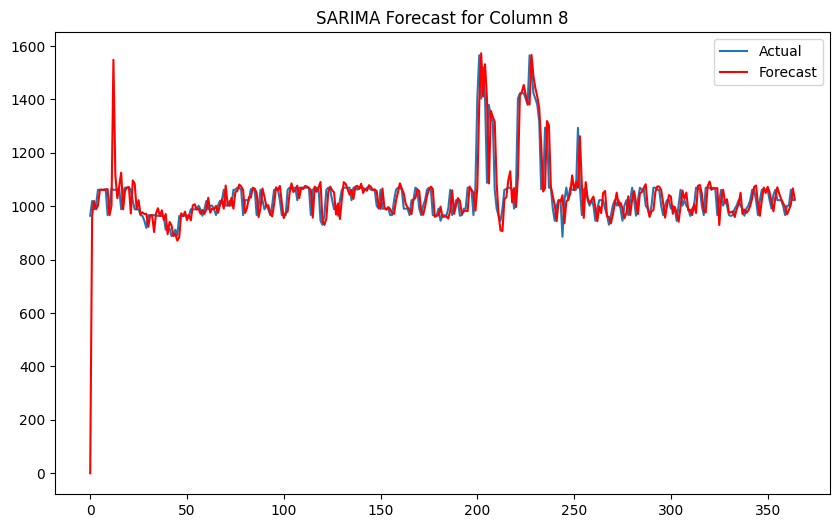

In [300]:
series = data.iloc[:, 7]

# Điền giá trị thiếu bằng phương pháp nội suy (interpolation)
series = series.interpolate(method='linear')

# Dự đoán giá trị
n_forecast = len(series)
forecast = model_fit.predict(start=0, end=n_forecast-1)

# Tính toán độ đo lỗi
mse = mean_squared_error(series, forecast)
mae = mean_absolute_error(series, forecast)
rmse = np.sqrt(mse)

print("SARIMA - MSE:", mse)
print("SARIMA - MAE:", mae)
print("SARIMA - RMSE:", rmse)

# Vẽ biểu đồ kết quả dự đoán
plt.figure(figsize=(10, 6))
plt.plot(series, label='Actual')
plt.plot(forecast, label='Forecast', color='red')
plt.title('SARIMA Forecast for Column 8')
plt.legend()
plt.show()
